In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score

import seaborn as sns

# Juntandos os dados em um único DataFrame

In [3]:
def get_data_gathered(cities: list[str] = ['cleveland'], save: bool = False) -> pd.DataFrame:
    columns = [
        'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'
    ]

    def load_data(file_path: str) -> pd.DataFrame:
        df = pd.read_csv(file_path, header=None, names=columns, na_values='?')
        return df

    files: list[str] = [f'./data/processed.{city}.data' for city in cities]

    result_df = pd.concat([load_data(file)
                          for file in files], ignore_index=True)
    if save:

        output_path = f'./data/heart_disease_{"_".join(cities)}.csv'
        result_df.to_csv(output_path, index=False)
        print(f"Arquivo CSV criado com sucesso em: {output_path}")

    return result_df

# Pré processamento dos dados

Foram implementadas 2 alternativas para teste, uma em que os valores nulos são preenchidos, e outra em que os valores nulos são removidos.

In [4]:
def deal_with_nil(original_df: pd.DataFrame, drop_nulls: bool = True) -> pd.DataFrame:
    if drop_nulls:
        return original_df.dropna()

    df = original_df.copy()
    # Substitua lacunas para frente do valor válido anterior em: 'trestbps'
    df = df.fillna({'trestbps': df['trestbps'].ffill()})
    # Substitua os valores ausentes pela média de cada coluna em: 'chol'
    df = df.fillna({'chol': df['chol'].mean()})
    # Substitua as lacunas do próximo valor válido em: 'fbs'
    df = df.fillna({'fbs': df['fbs'].bfill()})
    # Substitua os valores ausentes pela média de cada coluna em: 'thalach'
    df = df.fillna({'thalach': df['thalach'].mean()})
    # Substitua os valores ausentes pelo modo de cada coluna em: 'restecg'
    df = df.fillna({'restecg': df['restecg'].mode()[0]})
    # Substitua os valores ausentes pelo modo de cada coluna em: 'exang'
    df = df.fillna({'exang': df['exang'].mode()[0]})
    # Remover coluna: 'ca' (muitos nulls)
    df = df.drop(columns=['ca'])
    # Substitua lacunas para frente do valor válido anterior em: 'slope'
    df = df.fillna({'slope': df['slope'].ffill()})
    # Substitua os valores ausentes pelo modo de cada coluna em: 'thal'
    df = df.fillna({'thal': df['thal'].mode()[0]})
    # Substitua lacunas para frente do valor válido anterior em: 'oldpeak'
    df = df.fillna({'oldpeak': df['oldpeak'].ffill()})
    return df

Para a normalização foi usado o MinMaxScaler, que transforma os dados para que fiquem entre 0 e 1. Transformando a coluna objetivo em 0 e 1. Onde 0 é saudável e 1 é doente, no banco de dados original os valores são [0..4], onde qualquer número >0 é não saudável.

In [5]:
def normalize(original_df: pd.DataFrame) -> pd.DataFrame:
    df_clean = original_df.copy()
    print("Quantidade de classes nos dados limpos:")
    print(df_clean['num'].value_counts())

    df_clean['num'] = df_clean['num'].apply(
        lambda x: 0 if x == 0 else 1)

    scaler = MinMaxScaler()
    df_clean_normalized = df_clean.copy()
    df_clean_normalized = pd.DataFrame(scaler.fit_transform(
        df_clean_normalized), columns=df_clean_normalized.columns)

    df_clean_normalized.describe()

    df_clean_normalized['num'] = df_clean_normalized['num'].astype(bool)

    print("Quantidade de classes nos dados normalizados:")
    print(df_clean_normalized['num'].value_counts())

    return df_clean_normalized

In [ ]:
df: pd.DataFrame = normalize(deal_with_nil(get_data_gathered()))

df.head()

Quantidade de classes nos dados limpos:
num
0    160
1     54
2     35
3     35
4     13
Name: count, dtype: int64
Quantidade de classes nos dados normalizados:
num
False    160
True     137
Name: count, dtype: int64


# Replicando a arquitetura do artigo

| Parâmetro                | Valor       |
|--------------------------|-------------|
| Neurônios na camada de entrada | 12          |
| Neurônios na camada de saída   | 2           |
| Camadas ocultas               | 1            |
| Neurônios na camada oculta    | 6            |
| Épocas                        | 2000         |
| Taxa de aprendizado           | 0.32         |
| Momento                       | 0.72         |
| Performance                   | 0.199        |

In [7]:
X = df.drop('num', axis=1)
y = df['num']

## Dividindo em treino e teste 60:40
Foi feito assim como no artigo

In [15]:
np.random.seed(42)
model_60_40 = MLPClassifier(hidden_layer_sizes=(
    6,), max_iter=2000, learning_rate_init=0.32, momentum=0.72, activation='logistic')

# Divide o dataset em 60% treino e 40% teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42)

# Exibe os tamanhos dos conjuntos de treino e teste
print(f'Tamanho do conjunto de treino: {X_train.shape[0]}')
print(f'Tamanho do conjunto de teste: {X_test.shape[0]}')

Tamanho do conjunto de treino: 178
Tamanho do conjunto de teste: 119


## Treinamento do modelo

Matriz de Confusão:
[[48 12]
 [20 39]]
Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.71      0.80      0.75        60
        True       0.76      0.66      0.71        59

    accuracy                           0.73       119
   macro avg       0.74      0.73      0.73       119
weighted avg       0.74      0.73      0.73       119



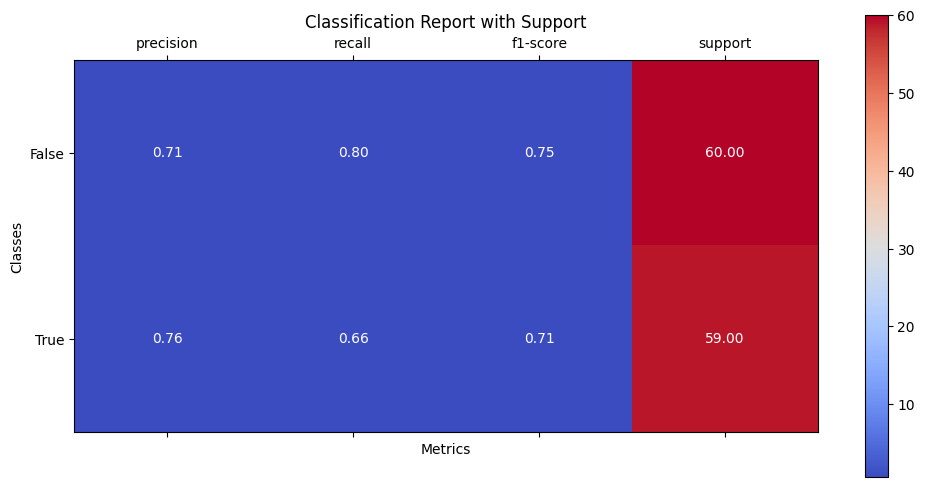

F1-Score: 0.7090909090909091
Score: 0.7310924369747899


In [16]:
model_60_40.fit(X_train, y_train)
score = model_60_40.score(X_test, y_test)

y_pred = model_60_40.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print('Matriz de Confusão:')
print(conf_matrix)

cr = classification_report(y_test, y_pred)
print('Relatório de Classificação:')
print(cr)


def plot_classification_report_with_support(report):
    # Exclude 'accuracy', 'macro avg', 'weighted avg'
    labels = list(report.keys())[:-3]
    metrics = ['precision', 'recall', 'f1-score', 'support']
    data = np.array([[report[label][metric]
                    for metric in metrics] for label in labels])
    _, ax = plt.subplots(figsize=(12, 6))
    cax = ax.matshow(data, cmap='coolwarm')
    plt.xticks(range(len(metrics)), metrics)
    plt.yticks(range(len(labels)), labels)
    plt.colorbar(cax)
    for (i, j), val in np.ndenumerate(data):
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='white')
    plt.xlabel('Metrics')
    plt.ylabel('Classes')
    plt.title('Classification Report with Support')
    plt.show()


# Plotting the classification report with support
plot_classification_report_with_support(
    classification_report(y_test, y_pred, output_dict=True)
)
print(f'F1-Score: {f1_score(y_test, y_pred)}')
print(f"Score: {score}")

## Plotando a matriz de confusão

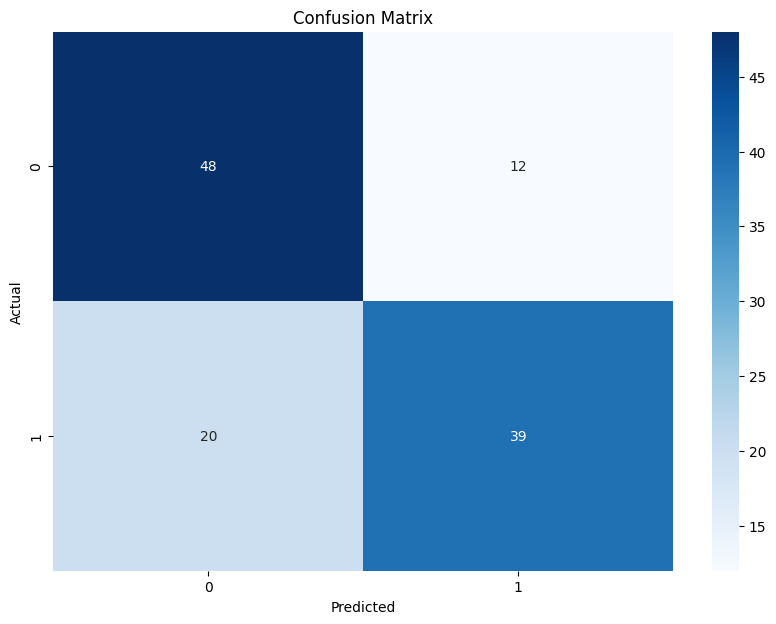

In [17]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Primeira modificação: K Fold

Nesta modificação iremos usar **kfold** com [2..20] splits ao invés de dividir em 60:40

In [18]:
all_results = {}
experiments = 100
for splits in range(2, 21):
    split_results = []
    for seed in range(experiments+1):
        np.random.seed(seed)
        kf = KFold(n_splits=splits, shuffle=True)

        model_kfold = MLPClassifier(hidden_layer_sizes=(
            6,), max_iter=2000, learning_rate_init=0.32, momentum=0.72, activation='logistic')

        count = 0
        scores = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            count += 1
            model_kfold.fit(X_train, y_train)
            score = model_kfold.score(X_test, y_test)
            scores.append(score)
        
        split_results.append(np.mean(scores))
    all_results[splits] = np.mean(split_results)

# Descobre melhor quantidade de splits e score médio
best_splits = max(all_results, key=all_results.get)
best_score = all_results[best_splits]

print(f'Melhor quantidade de splits: {best_splits}')
print(f'Score médio: {best_score}')

/home/yurih/ufu/ic/heart-disease-ann/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


## Segunda modificação: Épocas

Aqui variamos o número de épocas da arquitetura original.

O valor incial utilizado foi 400, pois ao utilizar 200 a biblioca exibia avisos que não estava convergindo.

In [ ]:
# Variar número de épocas iterando de 400 em 400 até 3000
num_experiments = 100
epochs_range = range(400, 3000, 200)
all_results = {}
for epochs in epochs_range:
    epoch_results = []
    for seed in range(num_experiments + 1):
        np.random.seed(seed)
        model_60_40 = MLPClassifier(hidden_layer_sizes=(
            6,), max_iter=epochs, learning_rate_init=0.32, momentum=0.72, activation='logistic')
        
        model_60_40.fit(X_train, y_train)
        score = model_60_40.score(X_test, y_test)

        epoch_results.append(score)
    
    # Salva a média dos resultados de cada época
    all_results[epochs] = np.mean(epoch_results)

# Descobrir o melhor número de épocas
best_epoch = max(all_results, key=all_results.get)
best_score = all_results[best_epoch]

print(f'Melhor quantidade de épocas: {best_splits}')
print(f'Score médio: {best_score}')


(1800, np.float64(0.816579963081054))


## Terceira Modificação: Função de Ativação

Aqui testamos a arquitetura original com outras funções de ativação (relu, identity, tanh).

In [81]:
activation_functions = ['relu', 'identity', 'tanh']
experiments = 100
all_results = {}
for function in activation_functions:
    function_results = []
    for seed in range(experiments + 1):
        np.random.seed(seed)
        model_60_40 = MLPClassifier(hidden_layer_sizes=(
            6,), max_iter=2000, learning_rate_init=0.32, momentum=0.72, activation=function)
        
        model_60_40.fit(X_train, y_train)
        score = model_60_40.score(X_test, y_test)

        function_results.append(np.mean(score))
    all_results[function] = np.mean(function_results)

# Descobrir a melhor função de ativação
best_function = max(all_results, key=all_results.get)
best_score = all_results[best_function]

print(f'Melhor função de ativação: {best_splits}')
print(f'Score médio: {best_score}')

('identity', 0.864406779661017)


## Quarta Moficação: Número de Neurônios